# Creamos bucles para el entrenamiento sistematico  
Esto incluye la carga de datos una vez (o varias si no nos cabe en memoria). Y luego el entrenamiento recursivo de modelos con diferentes parámetros. 

Tenemos que automatizar y hacer un buen control de errores en: 

    - Carga de datos.  
        - La carga y el creado de barches etc.  
    - Entrenamiento de modelos.  
    - Sacar las metricas oportunas.  

### Primera parte: Crear bucle carga de datos 

Vamos a tener en cuenta:  
1. Que los datos se carge en memoria todos si caben.  
2. Crear diferentes labels, para poder probar las diferentes opciones de agrupación.
    - Lo hacemos para probar cual es la mejor agrupación. 
    
**El tema de diferentes labels lo ponemos pendiente, por ahora tiramos con las que sabemos que funcionan, que son:**  
- Gamma  
- Electron  
- Hadrones

In [1]:
import sys
sys.path.append('../src/CTA-data-analisis-library/')

In [2]:
#cargamos librerias 
import os 
import subprocess
from datetime import datetime
import numpy as np 
import glob
import matplotlib.pyplot as plt
import tensorflow as tf 
import psutil
import re
import random
import shutil
import pickle

#propias
import unzipdata_and_first_treatments as manipulate
import loaddata4use
import model_creation_functions as models

### Primero vamos a experimentar con el tema de la memoria, para poder entrenar al máximo sin que se quede colgado

Tenemos muy poca ram disponible, por ello, vamos a optar por una alternativa de entrenamiento por fases, intentando que el modelo vea todos los datos posibles, pero que no olvide o se vea sesgado por subconjuntos de datos que se desvíen mucho de la distribución general de estos.

In [3]:
#enviroment variables
npy_final_dir="../datos/elementos_npy"
base_dir_elementos="../datos/elementos"
elements=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']

Buenos, podemos ver como los archivos de gamma son mucho más pesados, 4 veces o más. 

La idea va a ser hacer un boostrap (no se si es exactamente eso, pero creo que sí). En el que vayamos cogiendo de un conjunto grande de train, vamos a ir escogiendo aleatoriamente, y finalmente, tras muchas cargas entrenamientos y tal, en teoría el modelo las habra visto todas en un orden aleatorio, repitiendo etc.

**Por el momento no voy a hacer un tratamiento intensivo del desbalanceo.**  
**Voy a separar un 10% de las npy files en otro directorio para que podamos coger aleatoriamente del directorio npy_base**

```{bash}
[arturoSF@invidere datos]$ ls elementos_npy_test/*/*.npy | wc -l  
1456  
[arturoSF@invidere datos]$ ls elementos_npy/*/*.npy | wc -l  
6225  
```

### Ciclo de carga de datos 

La idea es cargar x datos en memoria y entrenar, luego cargar otra vez aleatoriamente x datos y sigue.  
Pero la duda es cuantos cargar, porque solo tenemos 5 Gb disponibles y esto aun sin contar con que tenemos el modelo en memoria.


#### Troubleshoting main_list
Necesitamos crear la main_list pero a partir de lo que tenemos disponible, entonces, lo que vamos a hacer es una funcion que escoja segun lo disponible y punto, lo único que necesitamos es extraer las runs disponibles para cada elemento.

In [4]:
def runs_disponibles(npy_dir,elements):
    lista=[]
    for i in elements:
        npy_element_dir=os.path.join(npy_dir,"npy_"+i)
        runs=[int(re.search("run_([0-9]{3})_0\.npy",i).group(1)) for i in os.listdir(npy_element_dir) if re.search("run_([0-9]{3})_0\.npy",i)]
        lista.append(runs)
    return lista

In [5]:

res=[np.array(i) for i in runs_disponibles(npy_final_dir,elements)]
total={}
for i in range(1,180):
    aux=[]
    for j in res:
        aux.append(np.sum(j==i))
        
    total[str(i)]=aux
      
for i in total:
    if ((1 in total[i]) | (2 in total[i]) | (3 in total[i])):
        print("Para la run:", i," hay problemas. ", total[i])

Para la run: 2  hay problemas.  [2, 0, 4, 0, 4, 4, 4]
Para la run: 3  hay problemas.  [3, 4, 4, 4, 4, 4, 4]


Ahora ya tenemos todas las opciones de runs a correr, solo vamos a quitar nosotros la 2 y la 3 de gamma a mano, que dan problemas, y el estos se elegiran de forma aleatoria.

In [6]:
chose_runs=runs_disponibles(npy_final_dir,elements)
chose_runs[0].remove(2)
chose_runs[0].remove(2)
chose_runs[0].remove(3)
chose_runs[0].remove(3)
chose_runs[0].remove(3)
#rapido y mal

In [7]:
def new_create_main_list_runs(number_runs_per_element,posibles_runs):
    #esto es aleatorio por defecto, porque es lo unico que necesito por ahora    
    final=[]
    for ind,lista_runs_element in enumerate(chose_runs):
        final.append(random.sample(lista_runs_element,number_runs_per_element[ind]))
    return final

In [8]:
#prueba de carga de datos 

#en lugar de usar esta carga de datos
#list_runs=loaddata4use.create_main_list_runs(num_events=2,init_events=4)

#usamos esta otra
list_runs=new_create_main_list_runs([6,9,9,9,9,9,9],chose_runs)
list_runs

[[24, 29, 25, 33, 45, 17],
 [100, 84, 10, 30, 8, 81, 12, 26, 4],
 [141, 98, 83, 154, 56, 128, 156, 75, 144],
 [101, 28, 24, 5, 43, 9, 128, 129, 122],
 [4, 162, 16, 2, 114, 169, 82, 117, 79],
 [127, 104, 7, 131, 56, 39, 67, 18, 103],
 [53, 56, 13, 68, 46, 61, 58, 37, 96]]

In [9]:
x_train_list,x_test_list,y_train_list,y_test_list=loaddata4use.load_dataset_completo(npy_final_dir,labels_asign=[0,1,2,2,2,2,2],elements=elements,
                                                                                     main_list_runs=list_runs,pre_name_folders="npy_",telescopes=[1,2,3,4],
                                                                                     test_size=0.05,same_quant="same",verbose=True,fill=True,categorical=True)

Load of names and common events
_______________
0 ;  Element:  gamma  , Runs:  [24, 29, 25, 33, 45, 17]  Shape of common events (tels,common events):  (4, 1117)
1 ;  Element:  gamma  , Runs:  [24, 29, 25, 33, 45, 17]  Shape of common events (tels,common events):  (4, 1094)
2 ;  Element:  gamma  , Runs:  [24, 29, 25, 33, 45, 17]  Shape of common events (tels,common events):  (4, 1082)
3 ;  Element:  gamma  , Runs:  [24, 29, 25, 33, 45, 17]  Shape of common events (tels,common events):  (4, 1137)
4 ;  Element:  gamma  , Runs:  [24, 29, 25, 33, 45, 17]  Shape of common events (tels,common events):  (4, 1143)
5 ;  Element:  gamma  , Runs:  [24, 29, 25, 33, 45, 17]  Shape of common events (tels,common events):  (4, 1116)
0 ;  Element:  electron  , Runs:  [100, 84, 10, 30, 8, 81, 12, 26, 4]  Shape of common events (tels,common events):  (4, 251)
1 ;  Element:  electron  , Runs:  [100, 84, 10, 30, 8, 81, 12, 26, 4]  Shape of common events (tels,common events):  (4, 245)
2 ;  Element:  electro

Element:  nitrogen , Telescope:  1  Shape of loaded array (amount of images, size of images):  (1438, 93, 55)
Element:  silicon , Telescope:  1  Shape of loaded array (amount of images, size of images):  (1438, 93, 55)
Element:  gamma , Telescope:  2  Shape of loaded array (amount of images, size of images):  (1438, 93, 55)
Element:  electron , Telescope:  2  Shape of loaded array (amount of images, size of images):  (1438, 93, 55)
Element:  proton , Telescope:  2  Shape of loaded array (amount of images, size of images):  (1438, 93, 55)
Element:  helium , Telescope:  2  Shape of loaded array (amount of images, size of images):  (1438, 93, 55)
Element:  iron , Telescope:  2  Shape of loaded array (amount of images, size of images):  (1438, 93, 55)
Element:  nitrogen , Telescope:  2  Shape of loaded array (amount of images, size of images):  (1438, 93, 55)
Element:  silicon , Telescope:  2  Shape of loaded array (amount of images, size of images):  (1438, 93, 55)
Element:  gamma , Teles

In [10]:
#tenemos que hacer un ligero cambio porque se estan cargando con los ejes cambiados
def cambiar_ejes_lista(lista):
    for i,j in enumerate(lista):
        lista[i]=np.swapaxes(j,1,2)
    return lista

x_train_list=cambiar_ejes_lista(x_train_list)
x_test_list=cambiar_ejes_lista(x_test_list)


Ya hemos reproducido la carga de datos de una manera que además nos va a permitir hacer un boostrap para entrenar con recursos limitados.  

Ahora tenemos que ver una forma optima de entrenar los modelos de forma automática.

De este notebook voy a reutilizar las funcions que sacan los runs y que nos dan las main_listas, y con ello, en un script de pipeline, lo llamaré despues con un script de automatizaciones. 

In [11]:
opciones_filtros=[
    [[12,16],[32,64],[64,12]],
    [[12,16,32],[64,128],[128,64,32]],
    [[12,16],[32,64],[64,12]],
    [[12,16],[32,64],[64,12]],
    [[12,16],[32,64],[64,12]]
]

In [12]:
modelo=models.model_multi_tel(classes=3,filtros=opciones_filtros[1],last_dense=[20,10])
modelo.summary()

2022-11-09 02:57:13.516588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 02:57:13.564493: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 55, 93, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 55, 93, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 55, 93, 1)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 55, 93, 1)]  0           []                               
                                                                                              

In [13]:
modelo.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["acc","AUC","mean_squared_error"])

In [14]:
hist=modelo.fit(x=x_train_list,y=y_train_list,epochs=15, validation_data=(x_test_list,y_test_list),batch_size=64)
modelo.save("../modelos/modelo_1.h5")
with open("../modelos/performances/history_modelo_1.pickle","wb") as pick:
    pickle.dump(hist,pick)

Epoch 1/15
150/150 [==============================] - 1836s 12s/step - loss: 0.7191 - acc: 0.7872 - auc: 0.9283 - mean_squared_error: 0.0989 - val_loss: 0.4699 - val_acc: 0.8591 - val_auc: 0.9695 - val_mean_squared_error: 0.0630
Epoch 2/15
150/150 [==============================] - 1828s 12s/step - loss: 0.4498 - acc: 0.8729 - auc: 0.9708 - mean_squared_error: 0.0617 - val_loss: 0.3987 - val_acc: 0.8750 - val_auc: 0.9761 - val_mean_squared_error: 0.0575
Epoch 3/15
150/150 [==============================] - 1833s 12s/step - loss: 0.3716 - acc: 0.8959 - auc: 0.9797 - mean_squared_error: 0.0512 - val_loss: 0.4064 - val_acc: 0.8571 - val_auc: 0.9726 - val_mean_squared_error: 0.0624
Epoch 4/15
150/150 [==============================] - 1834s 12s/step - loss: 0.3297 - acc: 0.9055 - auc: 0.9831 - mean_squared_error: 0.0458 - val_loss: 0.3897 - val_acc: 0.8730 - val_auc: 0.9729 - val_mean_squared_error: 0.0606
Epoch 5/15
150/150 [==============================] - 1830s 12s/step - loss: 0.3234 

INFO:tensorflow:Assets written to: ram://298c8dec-a564-4126-b4f0-f01fa2e5f87c/assets


INFO:tensorflow:Assets written to: ram://298c8dec-a564-4126-b4f0-f01fa2e5f87c/assets


In [15]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [3]:
with open("../modelos/performances/history_modelo_1.pickle","rb") as pk:
    hist=pickle.load(pk)

2022-11-09 13:55:50.949735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 13:55:50.968130: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


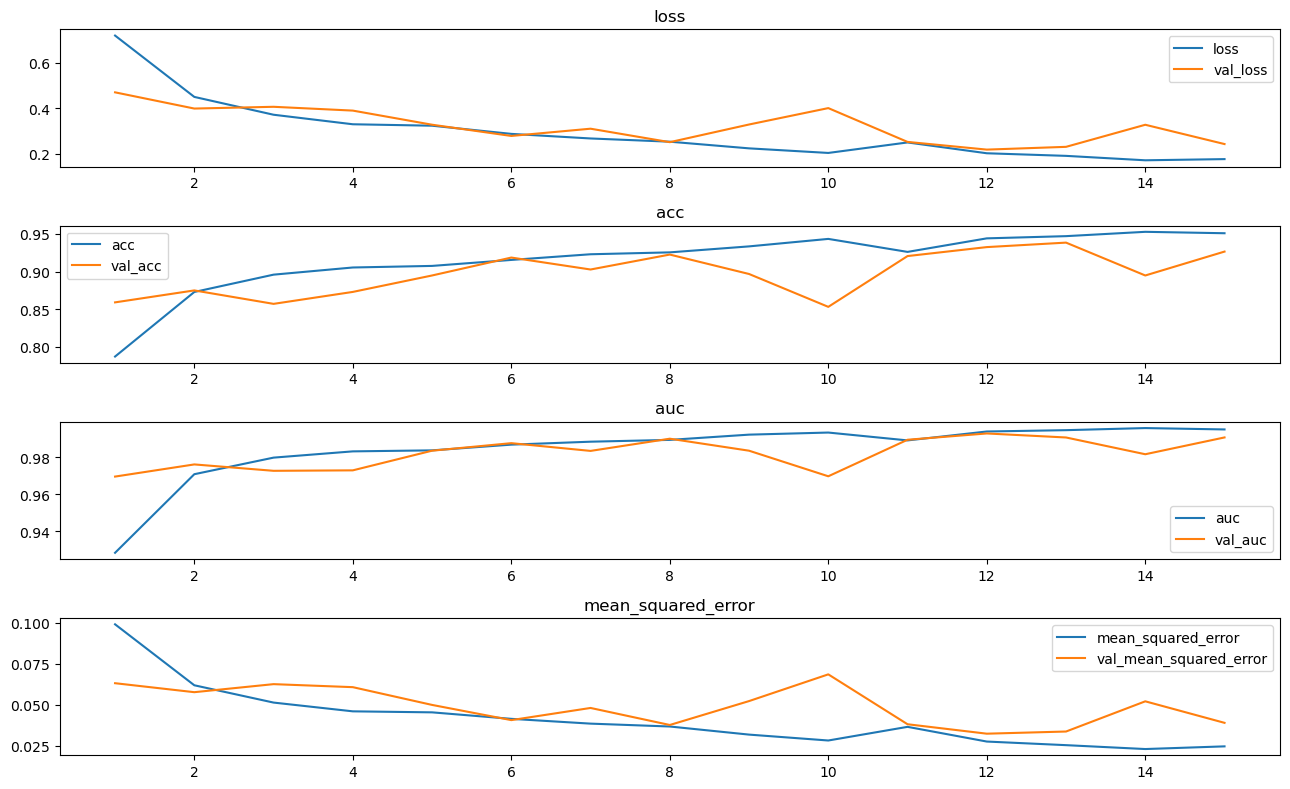

In [12]:
plt.figure(figsize=(13,8))
for j,i in enumerate(hist.history):
    if not re.search("^val_",i):
        data_aux=hist.history[i]
        data_aux_2=hist.history["val_"+i]
        plt.subplot(4,1,j+1)
        plt.plot(np.arange(1,16),data_aux,label=i)
        plt.plot(np.arange(1,16),data_aux_2,label="val_"+i)
        plt.legend()
        plt.title(i)
plt.tight_layout()

In [8]:
hist.history.keys()

dict_keys(['loss', 'acc', 'auc', 'mean_squared_error', 'val_loss', 'val_acc', 'val_auc', 'val_mean_squared_error'])